In [1]:
import os
import sys
import pickle
import time

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import scipy
from scipy import stats
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

In [2]:
def load_predictions(parts_to_load, dataset):
    pred_objects = []
    for part in parts_to_load:
        filepath = os.path.join(
            RESULTS_PATH, 'predictions_nsrr_ss',
            'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
            'v2_time',
            'prediction_part%d.pkl' % part
        )
        with open(filepath, 'rb') as handle:
            pred_object = pickle.load(handle)
        pred_object.set_parent_dataset(dataset)
        pred_objects.append(pred_object)
    return pred_objects

# Load NSRR dataset and pre-computed predicted dataset

In [ ]:
parts_to_load = [0]  # 0 to 11

nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True, params={pkeys.PAGE_DURATION: 30})
pred_objects = load_predictions(parts_to_load, nsrr)

<h1> Dataset de parámetros</h1>

Parámetros no definidos son NaN.

In [2]:
# Filenames of dataset checkpoints
byevent_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent.csv'
)
bysubject_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_bysubject.csv'
)

In [3]:
params_load_checkpoint = True

# ############################

if params_load_checkpoint:
    print("Loading from checkpoint")
    table_byevent = pd.read_csv(byevent_ckpt_path)
    table_bysubject = pd.read_csv(bysubject_ckpt_path)

else:
    # Perform computation and save checkpoint
    table_byevent = {
        'subject_id': [],
        'mark_id': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }
    table_bysubject = {
        'subject_id': [],
        'age': [], 
        'female': [],
        'n2_minutes': [],
        'n2_abs_sigma_power': [],
        'n2_rel_sigma_power': [],
        'n2_pl_exponent': [],
        'density': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }

    min_n2_minutes = 60
    verbose_min_minutes = False

    start_time = time.time()
    print("Generating table of parameters")
    for part_id, predictions in enumerate(pred_objects):
        print("Processing Part %d / %d" % (part_id + 1, len(pred_objects)))
        for subject_id in tqdm(predictions.all_ids):
            n2_pages = predictions.data[subject_id]['n2_pages']
            n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
            if n2_minutes < min_n2_minutes:
                if verbose_min_minutes:
                    print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
                continue

            # Now compute parameters
            subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
            signal = subject_data['signal']
            age = float(subject_data['age'].item())
            female = int(subject_data['sex'].item() == 'f')

            # By-subject spectral parameters
            signal_n2 = signal.reshape(-1, nsrr.fs * nsrr.original_page_duration)[n2_pages].flatten()
            freq, power = utils.power_spectrum_by_sliding_window(signal_n2, nsrr.fs, window_duration=5)
            # a) Absolute sigma power 
            n2_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
            # b) Relative sigma power (as in Lacourse)
            n2_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
            n2_rel_sigma_power = n2_abs_sigma_power / n2_broad_power
            # c) Power law exponent 2-30 Hz without sigma band (same as exclusion process)
            locs_to_use = np.where(((freq >= 2) & (freq < 10)) | ((freq > 17) & (freq <= 30)))[0]
            log_x = np.log(freq[locs_to_use])
            log_y = np.log(power[locs_to_use])
            n2_pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x, log_y)

            # Spindle parameters
            marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
            n_marks = marks.shape[0]
            density = n_marks / n2_minutes  # epm
            if n_marks == 0:
                # Dummy entries
                be_subject_id = [subject_id]
                be_mark_id = [np.nan]
                be_duration = [np.nan]
                be_amplitude = [np.nan]
                be_frequency = [np.nan]
            else:
                be_subject_id = [subject_id] * n_marks
                be_mark_id = np.arange(n_marks)

                be_duration = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

                filt_signal = param_filtering_fn(signal, nsrr.fs, constants.SPINDLE)
                signal_events = [filt_signal[e[0]:(e[1]+1)] for e in marks]

                be_amplitude = np.array([
                    param_amplitude_fn(s, nsrr.fs, constants.SPINDLE) for s in signal_events
                ])

                be_frequency = np.array([
                    param_frequency_fn(s, nsrr.fs) for s in signal_events
                ])

            # By-subject averages
            bs_duration = np.mean(be_duration)
            bs_amplitude = np.mean(be_amplitude)
            bs_frequency = np.mean(be_frequency)

            # Save parameters
            table_byevent['subject_id'].append(be_subject_id)
            table_byevent['mark_id'].append(be_mark_id)
            table_byevent['duration'].append(be_duration)
            table_byevent['amplitude'].append(be_amplitude)
            table_byevent['frequency'].append(be_frequency)

            table_bysubject['subject_id'].append(subject_id)
            table_bysubject['age'].append(age)
            table_bysubject['female'].append(female)
            table_bysubject['n2_minutes'].append(n2_minutes)
            table_bysubject['n2_abs_sigma_power'].append(n2_abs_sigma_power)
            table_bysubject['n2_rel_sigma_power'].append(n2_rel_sigma_power)
            table_bysubject['n2_pl_exponent'].append(n2_pl_exponent)
            table_bysubject['density'].append(density)
            table_bysubject['duration'].append(bs_duration)
            table_bysubject['amplitude'].append(bs_amplitude)
            table_bysubject['frequency'].append(bs_frequency) 
    end_time = time.time()
    et_time = (end_time - start_time) / 60  # minutes
    print("Elapsed time: %1.4f minutes" % et_time)
    
    for key in table_byevent:
        table_byevent[key] = np.concatenate(table_byevent[key])
    table_byevent = pd.DataFrame.from_dict(table_byevent)
    table_bysubject = pd.DataFrame.from_dict(table_bysubject)
   
    # Save checkpoint
    print("Saving checkpoint")
    table_byevent.to_csv(byevent_ckpt_path, index=False)
    table_bysubject.to_csv(bysubject_ckpt_path, index=False)
    print("Done.")

Loading from checkpoint


In [4]:
print(table_byevent.shape)
table_byevent.head()

(4388910, 5)


,subject_id,mark_id,duration,amplitude,frequency
0,ccshs-trec-1800034,0.0,0.44,24.371809,13.9
1,ccshs-trec-1800034,1.0,0.72,28.900696,14.8
2,ccshs-trec-1800034,2.0,1.48,23.536839,15.4
3,ccshs-trec-1800034,3.0,0.60,26.453024,15.2
4,ccshs-trec-1800034,4.0,0.64,68.478527,14.3


In [5]:
print(table_bysubject.shape)
table_bysubject.head()

(11224, 11)


,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency
0,ccshs-trec-1800034,17.40,1,163.0,0.386454,1.859941,-1.279945,10.907975,1.133948,46.325089,13.594488
1,ccshs-trec-1800038,17.40,1,217.5,0.308670,1.510728,-1.136783,7.549425,1.112424,39.498830,12.832521
2,ccshs-trec-1800065,17.68,1,222.5,0.226842,1.522630,-1.228495,5.914607,0.964498,31.354270,12.927128
3,ccshs-trec-1800074,17.86,1,214.0,0.284249,1.389635,-1.336513,5.200935,0.884205,39.964162,13.244205
4,ccshs-trec-1800078,17.77,0,238.0,0.253408,1.328701,-1.223523,4.504202,0.826045,31.966187,13.291325


# Final NSRR composition statistics

Measure number of subjects and N2 hours of each subdataset (consider also zero marks subjects because this table should be independent from the detector). The idea is to say: the dataset was reduced from X subjects/hours to Y subjects/hours. On this dataset, there are Z total spindle detections to analyze.

In [ ]:
table_bysubject['origin'] = [s.split("-")[0] for s in table_bysubject.subject_id.values]
table_bysubject.head()

In [ ]:
origin_stats = table_bysubject[["subject_id", "origin"]].groupby(by="origin").count()
origin_stats['hours'] = table_bysubject[["n2_minutes", "origin"]].groupby(by="origin").sum() / 60  # hours
origin_stats['min_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").min()
origin_stats['max_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").max()
origin_stats['female'] = table_bysubject[["female", "origin"]].groupby(by="origin").mean() * 100
print(origin_stats)
print("")
print("Total:")
print("Number of subjects:", len(table_bysubject))
print("Number of hours: %1.6f" % (table_bysubject["n2_minutes"].sum() / 60))
# print(origin_stats[["subject_id", "hours"]].sum())
print("Age:", table_bysubject["age"].min(), table_bysubject["age"].max())
print("Female:", 100 * table_bysubject["female"].mean())

In [ ]:
print("Subjects without detections:")
table_bysubject[table_bysubject['density'] <= 0]

In [ ]:
min_detections = 10

event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
subjects_with_few_detections = np.sum(event_counts < min_detections)
print("Subjects with less than %d detections: %d (%1.4f%%)" % (
    min_detections, subjects_with_few_detections, 100 * subjects_with_few_detections / len(table_bysubject)))

# Gráficos por evento (sin agrupar por demografía)

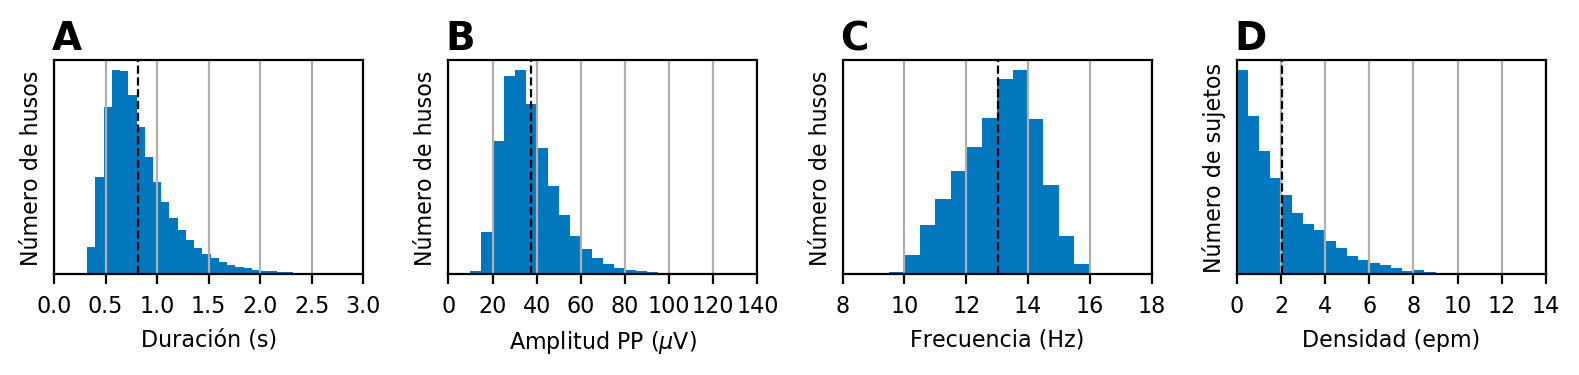

In [7]:
save_figure = True


table_byevent_valid = table_byevent.dropna()

fig, axes = plt.subplots(1, 4, figsize=(8, 2), dpi=200)

show_average = True

factor_to_lim = 1.05 #1.35 if show_average else 1.1

ax = axes[0]
n, _, _ = ax.hist(table_byevent_valid.duration.values, bins=np.arange(0.0, 3.0 + 0.001, 0.08), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Duración (s)", fontsize=8)
mean_value = np.mean(table_byevent_valid.duration.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.2f s" % mean_value)
ax.set_xticks(np.arange(0, 3 + 0.001, 0.5))
ax.set_xlim([0, 3])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[1]
n, _, _ = ax.hist(table_byevent_valid.amplitude.values, bins=np.arange(0, 135 + 0.001, 5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Amplitud PP ($\mu$V)", fontsize=8)
mean_value = np.mean(table_byevent_valid.amplitude.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f $\mu$V" % mean_value)
ax.set_xticks(np.arange(0, 140 + 0.001, 20))
ax.set_xlim([0, 140])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[2]
n, _, _ = ax.hist(table_byevent_valid.frequency.values, bins=np.arange(8.5, 17.5 + 0.001, 0.5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
mean_value = np.mean(table_byevent_valid.frequency.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f Hz" % mean_value)
ax.set_xticks(np.arange(8, 18 + 0.001, 2))
ax.set_xlim([8, 18])
ax.set_ylabel("Número de husos", fontsize=8)

# oscilaciones
#ax = axes[3]
#oscils = table_byevent_valid.frequency.values * table_byevent_valid.duration.values
#n, _, _ = ax.hist(oscils, color=viz.PALETTE['blue'], bins=np.arange(0, 50 + 0.001, 2.5))
#max_count = np.max(n)
#ax.set_ylim([0, factor_to_lim * max_count])
#ax.set_xlabel("Oscilaciones", fontsize=8)
#mean_value = np.mean(oscils)
#ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f" % mean_value)
#ax.set_xticks(np.arange(0, 50 + 0.001, 5))
#ax.set_xlim([0, 50])

# Densidad 
ax = axes[3]
n, _, _ = ax.hist(table_bysubject.density.values, color=viz.PALETTE['blue'], bins=np.arange(0, 14 + 0.001, 0.5))
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Densidad (epm)", fontsize=8)
mean_value = np.mean(table_bysubject.density.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f epm" % mean_value)
ax.set_xticks(np.arange(0, 14 + 0.001, 2))
ax.set_xlim([0, 14])
ax.set_ylabel("Número de sujetos", fontsize=8)


for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.grid()
    #if show_average:
    #    ax.legend(loc="upper right", fontsize=8, frameon=True)
    ax.text(
        x=-0.01, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_hist"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

In [ ]:
# Tabla latex
vectors_dict = {
    'Duración (s)': table_byevent_valid.duration.values,
    'Amplitud PP ($\mu$V)': table_byevent_valid.amplitude.values,
    'Frecuencia (Hz)': table_byevent_valid.frequency.values,
    'Densidad (epm)': table_bysubject.density.values,
}
print("Parámetro & Promedio & Intervalo 50\% & Intervalo 90\% \\\\")
for param_name in vectors_dict.keys():
    vector = vectors_dict[param_name]
    mean_val = vector.mean()
    p5, p25, p50, p75, p95 = np.percentile(vector, (5, 25, 50, 75, 95))
    print("%s & %1.4f & %1.4f -- %1.4f & %1.4f -- %1.4f \\\\" % (param_name, mean_val, p25, p75, p5, p95))


# Gráficos de densidad vs potencia en banda sigma

In [8]:
moda = load_dataset(constants.MODA_SS_NAME, load_checkpoint=True)

moda_table = {
    'density': [],
    'n2_rel_sigma_power': [],
    'n2_abs_sigma_power': [],
    'n2_minutes': []
}

for subject_id in moda.all_ids:
    signal = moda.get_subject_signal(subject_id, normalize_clip=False)
    marks = moda.get_subject_stamps(subject_id, pages_subset='n2')
    n2_pages = moda.get_subject_pages(subject_id, pages_subset='n2')
    n2_minutes = n2_pages.size * moda.page_duration / 60
    density = marks.shape[0] / n2_minutes
    # By-subject spectral parameters
    signal_n2 = signal.reshape(-1, moda.page_size)[n2_pages].flatten()
    freq, power = utils.power_spectrum_by_sliding_window(signal_n2, moda.fs, window_duration=5)
    # a) Absolute sigma power 
    n2_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
    # b) Relative sigma power (as in Lacourse)
    n2_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
    n2_rel_sigma_power = n2_abs_sigma_power / n2_broad_power
    moda_table['density'].append(density)
    moda_table['n2_rel_sigma_power'].append(n2_rel_sigma_power)
    moda_table['n2_abs_sigma_power'].append(n2_abs_sigma_power)
    moda_table['n2_minutes'].append(n2_minutes)
moda_table = pd.DataFrame.from_dict(moda_table)
moda_table.head()

Dataset moda_ss with 180 patients.
Loading from checkpoint... Loaded
Global STD: None


,density,n2_rel_sigma_power,n2_abs_sigma_power,n2_minutes
0,5.950000,1.401505,0.280512,20.0
1,0.833333,1.115699,0.186558,6.0
2,6.166667,1.322975,0.219179,6.0
3,2.000000,1.131767,0.160345,6.0
4,1.000000,1.195480,0.148513,6.0


There are 348 subjects (3.1 %) with density less than 0.10 epm


/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecat

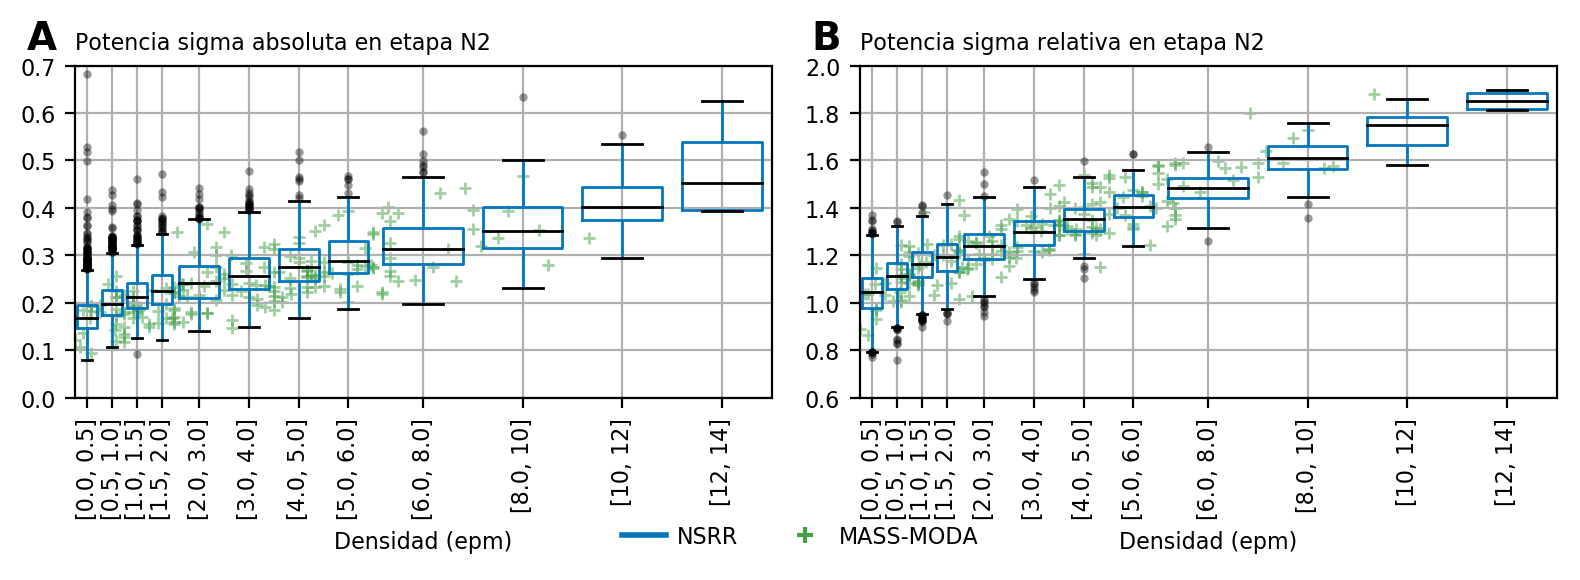

In [54]:
save_figure = True

density_thr_to_print = 0.1
n_below = np.sum(table_bysubject.density < density_thr_to_print)
n_total = len(table_bysubject)
print("There are %d subjects (%1.1f %%) with density less than %1.2f epm" % (n_below, 100 * n_below / n_total, density_thr_to_print))

bins = np.concatenate([
    np.arange(0, 2+0.001, 0.5),
    np.arange(3, 5+0.001, 1),
    np.arange(6, 14+0.001, 2)
])
positions = bins[:-1] + np.diff(bins)/2
widths = 0.8*np.diff(bins)
df = table_bysubject.copy()
df['density_bin'] = pd.cut(table_bysubject.density, bins=bins)#[0, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14])

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
df.boxplot(
    column=["n2_abs_sigma_power", "n2_rel_sigma_power"],
    by="density_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
    positions=positions,
    widths=widths,
)

axes[0].plot(
    moda_table.density,
    moda_table.n2_abs_sigma_power,
    color=viz.PALETTE['green'], alpha=0.5,
    marker='+', markersize=4, linestyle="none", zorder=1
)
axes[1].plot(
    moda_table.density,
    moda_table.n2_rel_sigma_power,
    color=viz.PALETTE['green'], alpha=0.5,
    marker='+', markersize=4, linestyle="none", zorder=1
)


fig.suptitle('')
for i_ax, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel("Densidad (epm)", fontsize=8)
    ax.text(
        x=-0.07, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
axes[0].set_title("Potencia sigma absoluta en etapa N2", fontsize=8, loc="left")
axes[0].set_ylim([0, 0.7])
axes[1].set_title("Potencia sigma relativa en etapa N2", fontsize=8, loc="left")
axes[1].set_ylim([0.6, 2.0])
axes[0].set_xlim([0, 14])
axes[1].set_xlim([0, 14])


def bin_to_str(bin_val):
    if bin_val >= 10:
        return '%d' % bin_val
    else:
        return '%1.1f' % bin_val


axes[0].set_xticks(positions)
axes[0].set_xticklabels(['[%s, %s]' % (bin_to_str(bins[i]), bin_to_str(bins[i+1])) for i in range(len(bins)-1)])
axes[1].set_xticks(positions)
axes[1].set_xticklabels(['[%s, %s]' % (bin_to_str(bins[i]), bin_to_str(bins[i+1])) for i in range(len(bins)-1)])
    
plt.tight_layout()

# Get legend
custom_lines = [Line2D([0], [0], color=viz.PALETTE['blue'], lw=2),
                Line2D([0], [0], color=viz.PALETTE['green'], marker="+", linestyle="none", markeredgewidth=1.5)]
labels = ["NSRR", "MASS-MODA"]
lg1 = fig.legend(
    custom_lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_density_power"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    
plt.show()

# Gráficos by-subject con suficientes detecciones

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


[ 493.   34.  285.   27.   19.   15.   17.  186.  207.  319.  442.  414.
  682. 1336. 1118.  656.  293.]
[552.  34. 292.  34.  21.  14.  26. 220. 265. 355. 520. 411. 397. 412.
 408. 435. 175.]


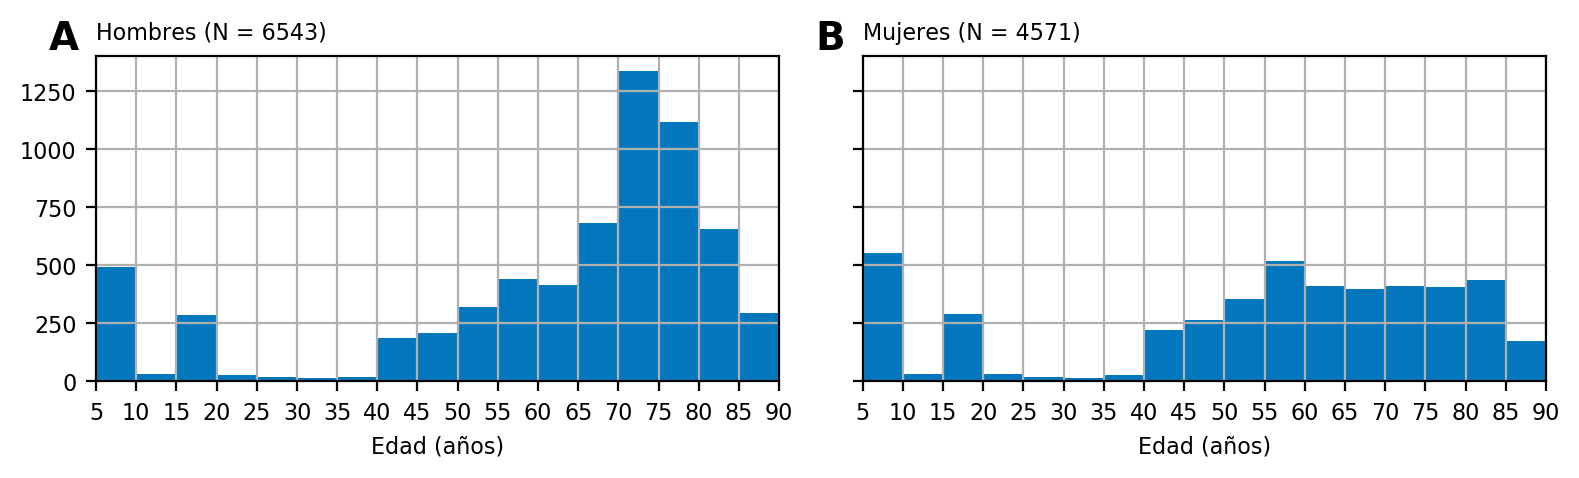

In [60]:
save_figure = True

# Demographics of subjects with enough detections
min_detections = 10
event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
enough_dets = table_bysubject[event_counts >= min_detections]

# Those with less than 5 years are three subjects with 4.5, 4.9 and 4.9 y.o.. For statistics purposes those
# subjects will be within the bin containing 5 years old.
enough_dets["age"] = np.clip(enough_dets["age"], a_min=5, a_max=None)

ages_m = enough_dets[enough_dets.female == 0]["age"].values
ages_f = enough_dets[enough_dets.female == 1]["age"].values

bins = np.arange(5, 90 + 0.001, 5)
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), dpi=200, sharey=True)

ax = axes[0]
n, _, _ = ax.hist(ages_m, bins=bins, color=viz.PALETTE['blue'])
ax.set_title("Hombres (N = %d)" % len(ages_m), fontsize=8, loc="left")
print(n)

ax = axes[1]
n, _, _ = ax.hist(ages_f, bins=bins, color=viz.PALETTE['blue'])
ax.set_title("Mujeres (N = %d)" % len(ages_f), fontsize=8, loc="left")
print(n)

for i_ax, ax in enumerate(axes):
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Edad (años)", fontsize=8)
    ax.set_xticks(bins)
    ax.grid()
    ax.set_xlim([bins[0], bins[-1]])
    ax.text(
        x=-0.07, y=1.02, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_composition"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


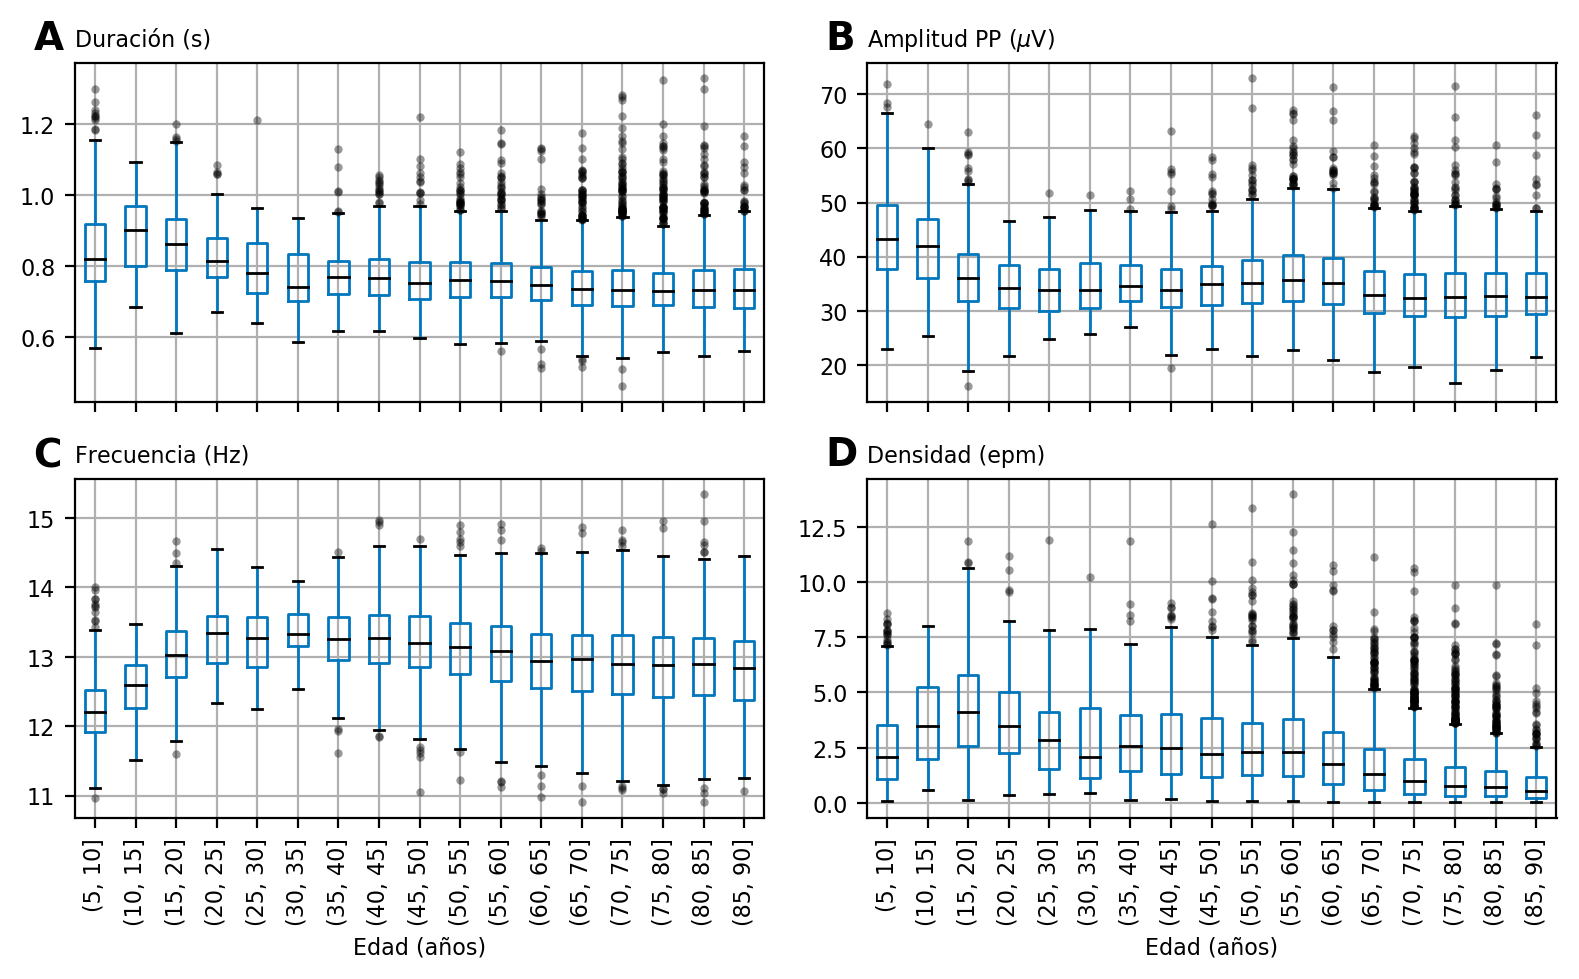

In [62]:
# by-subject params, age differences
save_figure = True

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=np.arange(5, 90 + 0.001, 5).astype(np.int32))

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=200, sharex=True)
df.boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by="age_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
)
fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.text(
        x=-0.06, y=1.04, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
axes[0, 0].set_title("Duración (s)", fontsize=8, loc="left")
axes[0, 1].set_title("Amplitud PP ($\mu$V)", fontsize=8, loc="left")
axes[1, 0].set_title("Frecuencia (Hz)", fontsize=8, loc="left")
axes[1, 1].set_title("Densidad (epm)", fontsize=8, loc="left")

axes[1, 0].set_xlabel("Edad (años)", fontsize=8)
axes[1, 1].set_xlabel("Edad (años)", fontsize=8)
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_age"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

In [63]:
def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p <= 0.05
        # ** is p <= 0.01
        # *** is p <= 0.001
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh/2)

    ax.plot(barx, bary, c='black', linewidth=0.8)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.annotate(text, mid, **kwargs)


Paramater duration, Age midpoint 8.5. female=0 with mean 0.8255 vs female=1 with mean 0.8555 (Diff -0.0300): P-value 0.0001
Paramater duration, Age midpoint 31.0. female=0 with mean 0.7975 vs female=1 with mean 0.8177 (Diff -0.0202): P-value 0.0000
Paramater duration, Age midpoint 70.0. female=0 with mean 0.7466 vs female=1 with mean 0.7614 (Diff -0.0147): P-value 0.0000

Paramater amplitude, Age midpoint 8.5. female=0 with mean 43.4679 vs female=1 with mean 44.0593 (Diff -0.5913): P-value 0.2935
Paramater amplitude, Age midpoint 31.0. female=0 with mean 34.1557 vs female=1 with mean 36.7921 (Diff -2.6364): P-value 0.0000
Paramater amplitude, Age midpoint 70.0. female=0 with mean 32.5417 vs female=1 with mean 37.1954 (Diff -4.6537): P-value 0.0000

Paramater frequency, Age midpoint 8.5. female=0 with mean 12.1696 vs female=1 with mean 12.3015 (Diff -0.1319): P-value 0.0000
Paramater frequency, Age midpoint 31.0. female=0 with mean 13.0715 vs female=1 with mean 13.2366 (Diff -0.1651): 

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


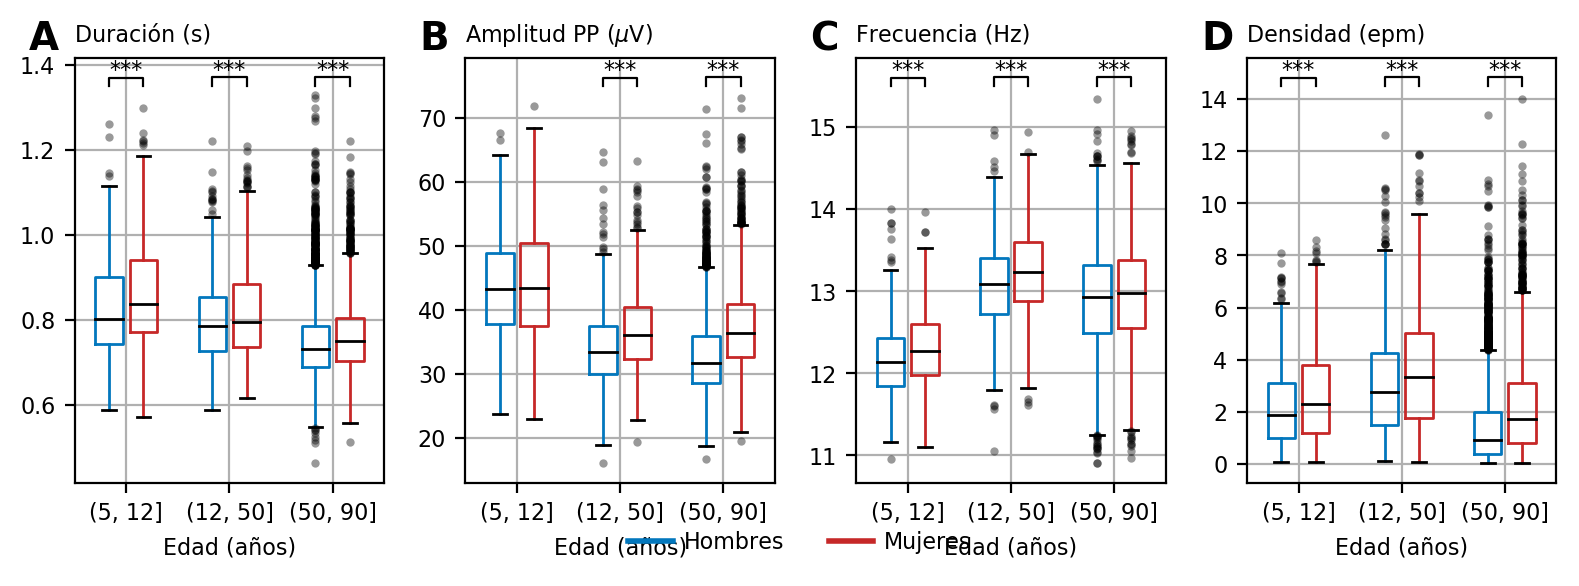

In [74]:
# by-subject params, sex differences
save_figure = True

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=[5, 12, 50, 90])

for param_name in ["duration", "amplitude", "frequency", "density"]:
    print("")
    for a in df.groupby(by="age_bin"):
        mid_age = a[0].mid
        data_l = []
        sex_l = []
        for b in a[1].groupby(by="female"):
            female = b[0]
            table = b[1]
            data_l.append(table[param_name].values)
            sex_l.append(female)
        # statistical test
        pvalue = stats.ttest_ind(data_l[0], data_l[1], equal_var=False)[1]
        print("Paramater %s, Age midpoint %1.1f. female=%d with mean %1.4f vs female=%d with mean %1.4f (Diff %1.4f): P-value %1.4f" % (
            param_name, mid_age,
            sex_l[0], data_l[0].mean(),
            sex_l[1], data_l[1].mean(),
            data_l[0].mean() - data_l[1].mean(),
            pvalue
        ))

fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=200, sharex=True)
df[df.female==0].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[0.75, 2.25, 3.75], widths=0.4,
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
)
df[df.female==1].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[1.25, 2.75, 4.25], widths=0.4, 
    boxprops=dict(color=viz.PALETTE['red']),
    whiskerprops=dict(color=viz.PALETTE['red']),
    medianprops=dict(color="k"),
)

fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlim([0.25, 4.75])
    ax.set_xticks([1, 2.5, 4])
    ax.set_xlabel("Edad (años)", fontsize=8)
    ax.text(
        x=-0.15, y=1.02, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
axes[0].set_title("Duración (s)", fontsize=8, loc="left")
axes[1].set_title("Amplitud PP ($\mu$V)", fontsize=8, loc="left")
axes[2].set_title("Frecuencia (Hz)", fontsize=8, loc="left")
axes[3].set_title("Densidad (epm)", fontsize=8, loc="left")

# P-values
positions = np.array([0.75, 1.25, 2.25, 2.75, 3.75, 4.25])
param_dict = {
    'duration': dict(ax=axes[0], max_value=1.35), # max_value=1.43),
    'amplitude': dict(ax=axes[1], max_value=75),#75),
    'frequency': dict(ax=axes[2], max_value=15.5),#15.5),
    'density': dict(ax=axes[3], max_value=14.5),#8),
}
for param_name in param_dict.keys():
    plot_specs = param_dict[param_name]
    for i, a in enumerate(df.groupby(by="age_bin")):
        data_l = []
        for b in a[1].groupby(by="female"):
            data_l.append(b[1][param_name].values)
        pvalue = stats.ttest_ind(data_l[0], data_l[1], equal_var=False)[1]
        if pvalue <= 0.001:
            p_text = '***'
        elif pvalue <= 0.01:
            p_text = '**'
        elif pvalue <= 0.05:
            p_text = '*'
        else:
            p_text = 'ns'
            continue
        barplot_annotate_brackets(plot_specs['ax'], 2 * i, 2 * i + 1, p_text, positions, len(positions) * [plot_specs['max_value']], fs=8, dh=0.0, barh=0.02)

plt.tight_layout()
        
# Get legend
custom_lines = [Line2D([0], [0], color=viz.PALETTE['blue'], lw=2),
                Line2D([0], [0], color=viz.PALETTE['red'], lw=2)]
labels = ["Hombres", "Mujeres"]
lg1 = fig.legend(
    custom_lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_sex"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)

plt.show()

# Oscilación de 0.02 Hz medida por distancia entre clusters

Seria interesarte desagregarlo por demografia en NSRR. Por ejemplo hombre, y mujer, y 5-18 años, 18-50 años, y 50-90 años.
18 por la mayoria de edad y 50 porque es el corte de las fases en moda. In Science paper, human subjects had between 18 to 28 y.o. and were all men. Seria bueno mostrar tambien la distribucion de los tamaños de los clusters para mostrar que son normalmente pequeños. Podria probar la robustez del resultado al criterio de clustering, por ejemplo probar {5, 10, 15, 20}.

In [ ]:
dataset = load_dataset('mass_ss', load_checkpoint=True, verbose=False)
expert = 1

subject_id = dataset.all_ids[0]
marks = dataset.get_subject_stamps(subject_id, which_expert=expert, pages_subset=constants.N2_RECORD)
n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)

In [ ]:
distances_l, clusters = get_distance_between_clusters(marks, n2_pages, dataset.page_size, dataset.fs, separation_to_join_seconds=10, return_clusters=True, shuffle=True, seed=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 2), dpi=100)
axes[0].hist(distances_l, bins=30)
axes[0].set_xlabel("Distancia (s)")
clusters_concat = np.concatenate(clusters, axis=0)
sizes = (clusters_concat[:, 1] - clusters_concat[:, 0] + 1) / dataset.fs
axes[1].hist(sizes, bins=30)
axes[1].set_xlabel("Tamaño (s)")
plt.tight_layout()
plt.show()

s = [(c.max() - c.min() + 1) for c in clusters]
max_length = np.max(s)
n_blocks = len(clusters)
matrix = np.zeros((n_blocks, max_length))
for i_c, c in enumerate(clusters):
    c = c - c.min()
    v = utils.stamp2seq(c, 0, max_length-1)
    matrix[i_c, :] = v

max_time_minutes = max_length / dataset.fs / 60
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
ax.imshow(matrix, aspect='auto', extent=(0, max_time_minutes, 1, n_blocks), cmap="binary")
ax.set_xticks(np.arange(0, max_time_minutes + 0.001, 1))
ax.grid(axis="x")
plt.show()

In [ ]:
def get_random_placement(durations, start_sample, end_sample, seed):
    durations = np.random.RandomState(seed=seed).permutation(durations)
    total_duration = np.sum(durations)
    
    n_gaps = len(durations) + 1
    samples_available_for_gaps = end_sample - start_sample + 1 - total_duration
    
    break_points = np.random.RandomState(seed=seed).choice(samples_available_for_gaps, size=n_gaps-1, replace=False)
    break_points = np.sort(break_points)
    
    gaps = np.diff(break_points, prepend=0, append=samples_available_for_gaps)

    last_sample = start_sample
    events = []
    for g, d in zip(gaps[:-1], durations):
        event_start = last_sample + g + 1
        event_end = event_start + d - 1
        events.append([event_start, event_end])
        last_sample = event_end
    events = np.stack(events, axis=0)
    return events


def split_into_blocks(pages_indices, min_block_length=1):
    split_points = np.where(np.diff(pages_indices) > 1)[0]
    split_points = split_points + 1
    end_locs = np.concatenate([split_points, [pages_indices.size - 1]])
    start_locs = np.concatenate([[0], split_points])
    blocks = []
    for start_loc, end_loc in zip(start_locs, end_locs):
        block = pages_indices[start_loc:end_loc]
        if len(block) >= min_block_length:
            blocks.append(block)
    return blocks


def get_distance_between_clusters(marks, n2_pages, page_size, fs, separation_to_join_seconds=10, return_clusters=False, shuffle=False, seed=0):
    # process blocks of contiguous N2 stages independently
    blocks = split_into_blocks(n2_pages)
    distances_l = []
    clusters_l = []
    for i_block, block in enumerate(blocks):
        start_sample = int(block[0] * page_size)
        end_sample = int((block[-1] + 1) * page_size)
        block_marks = utils.filter_stamps(marks, start_sample, end_sample)
        if block_marks.shape[0] < 2:
            # not enough clusters to measure distances
            continue
        
        if shuffle:
            seed_block = int(1e3 * seed) + i_block
            # ignore positions, only preserve lengths in n_samples
            durations = block_marks[:, 1] - block_marks[:, 0] + 1
            # relocate each duration
            block_marks = get_random_placement(durations, start_sample, end_sample, seed_block)
        
        # cluster marks
        clusters = stamp_correction.combine_close_stamps(block_marks, fs, separation_to_join_seconds)
        # remove marks that did not cluster (clean space between clusters)
        clusters = stamp_correction.filter_duration_stamps(clusters, fs, separation_to_join_seconds, None)
        
        if clusters.shape[0] < 2:
            # not enough clusters to measure distances
            continue
        # Get centers
        centers = clusters.mean(axis=1)
        # Get distances between centers in seconds
        distances_between_centers = np.diff(centers) / fs
        distances_l.append(distances_between_centers)
        clusters_l.append(clusters)
    
    if len(distances_l) == 0:
        distances_l = np.zeros((0, ))
    else:
        distances_l = np.concatenate(distances_l)
        
    if return_clusters:
        return distances_l, clusters_l
    else:
        return distances_l

In [ ]:
# Adjust clustering strategy most delicate parameter: the distance to cluster, using expert annotations
save_figure = False

print_dataset_map = {
    (constants.MASS_SS_NAME, 1): 'MASS-SS2-E1SS',
    (constants.MASS_SS_NAME, 2): 'MASS-SS2-E2SS',
    (constants.MODA_SS_NAME, 1): 'MASS-MODA',
    (constants.NSRR_SS_NAME, 1): 'NSRR',
}

configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1),
    #dict(dataset_name=constants.MASS_SS_NAME, expert=2),
    #dict(dataset_name=constants.MODA_SS_NAME, expert=1),
]

max_distance_minutes_for_pdf = 5  # minutes
max_distance_seconds = 60 * max_distance_minutes_for_pdf
distances_array = np.arange(0, max_distance_seconds + 1e-6, 0.01)

fig, axes = plt.subplots(2, 3, figsize=(8, 4), dpi=120)
for i_config, config in enumerate(configs):
    dataset_str = print_dataset_map[(config['dataset_name'], config['expert'])]
    
    dataset = load_dataset(config['dataset_name'], load_checkpoint=True, verbose=False)
    expert = config['expert']
    
    for separation_to_join_seconds in [5, 10, 15]: #[5, 7.5, 10, 12.5 ,15]:
    
        for i_s, shuffle in enumerate([False, True]):
    
            distances_l = []
            for i_subject, subject_id in enumerate(dataset.all_ids):
                #print("Sujeto", subject_id, "separacion", separation_to_join_seconds)
                marks = dataset.get_subject_stamps(subject_id, which_expert=expert, pages_subset=constants.N2_RECORD)
                n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
                subject_distances = get_distance_between_clusters(
                    marks, n2_pages, dataset.page_size, dataset.fs, 
                    separation_to_join_seconds=separation_to_join_seconds, 
                    return_clusters=False,
                    shuffle=shuffle,
                    seed=i_subject)
                distances_l.append(subject_distances)
            distances_l = np.concatenate(distances_l)

            # consider only those distances less than some meaningful value
            distances_valid = distances_l[distances_l <= max_distance_seconds]
            distance_pdf = stats.gaussian_kde(distances_valid)   
            distances_probability = distance_pdf(distances_array)

            axes[i_s, i_config].plot(distances_array, distances_probability, linewidth=1.0, label='%1.1f s' % separation_to_join_seconds)

    axes[0, i_config].set_title(dataset_str, fontsize=8, loc="left")
    axes[1, i_config].set_title('%s (aleatorio)' % dataset_str, fontsize=8, loc="left")
    
    
    
for i_ax, ax in enumerate(axes.flatten()):
    ax.set_xticks(np.arange(0, max_distance_seconds + 1e-6, 25))
    ax.grid(axis="x")
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.set_xlim([0, 200])
    ax.set_ylim([0, None])
    ax.text(
        x=-0.08, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    ax.set_xlabel("Distancia entre grupos (s)", fontsize=8)
    
plt.tight_layout()

# Get legend methods
labels_to_lines_dict = {}
for ax in axes.flatten():
    t_lines, t_labels = ax.get_legend_handles_labels()
    for lbl, lin in zip(t_labels, t_lines):
        labels_to_lines_dict[lbl] = lin
labels = list(labels_to_lines_dict.keys())
lines = [labels_to_lines_dict[lbl] for lbl in labels]
lg1 = fig.legend(
    lines, labels, fontsize=8, loc="lower center",
    bbox_to_anchor=(0.5, 0.02), ncol=len(labels), frameon=False, handletextpad=0.5)

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_params_clustering_fit"
    plt.savefig("%s.pdf" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_extra_artists=(lg1,), bbox_inches="tight", pad_inches=0.3)

plt.show()

In [ ]:
# Looking at MASS1 and MASS2, a clustering distance of 10s seems good to fit the known 50s oscillation.
# When using 10s, in MODA the mode of the distribution is smaller, like 30 something.
# In moda, there could be a problem because it is composed of 120s blocks, which is restrictive to capture the modal nature of the 50s gaps.
# But nevertheless there is like a minor peak at around 50 in MODA  when using 50s, so that is a good sign.
# Decision: 10s separation

In [ ]:
# Now measure the stuff in NSRR annotations and group by demographics
separation_to_join_seconds = 10



In [ ]:
parts_to_load = [0, 1, 2, 3]  # 0 to 11

nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True, params={pkeys.PAGE_DURATION: 30})
pred_objects = load_predictions(parts_to_load, nsrr)
demography = table_bysubject[['subject_id', 'age', 'female']].set_index('subject_id')

In [ ]:
min_n2_minutes = 60
min_distance_to_cluster = 10  # s
max_distance_minutes_to_consider = 5  # min

page_size = int(nsrr.fs * nsrr.original_page_duration)

distances_l = []
for predictions in pred_objects:
    for subject_id in predictions.all_ids:
        n2_pages = predictions.data[subject_id]['n2_pages']
        n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
        if n2_minutes < min_n2_minutes:
            continue
        marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
        n_marks = marks.shape[0]
        if n_marks == 0:
            continue
        
        # cluster marks
        marks = stamp_correction.combine_close_stamps(marks, nsrr.fs, min_distance_to_cluster)
        # remove marks that did not clustered
        marks = stamp_correction.filter_duration_stamps(marks, nsrr.fs, min_distance_to_cluster, None)
        
        # Process blocks independently
        blocks = split_into_blocks(n2_pages)
        for block in blocks:
            start_sample = int(block[0] * page_size)
            end_sample = int((block[-1] + 1) * page_size)
            block_marks = utils.filter_stamps(marks, start_sample, end_sample)
            if block_marks.shape[0] < 2:
                continue
            # Get centers
            centers = block_marks.mean(axis=1)
            # Get distances between centers in seconds
            distances_between_centers = np.diff(centers) / nsrr.fs
            distances_l.append(distances_between_centers)
# concat all
distances_l = np.concatenate(distances_l)

In [ ]:
# consider only those distances less than some meaningful value
max_distance_seconds = 60 * max_distance_minutes_to_consider
distances_valid = distances_l[distances_l <= max_distance_seconds]
distance_pdf = stats.gaussian_kde(distances_valid)

distances_array = np.arange(0, max_distance_seconds, 0.1)
distances_probability = distance_pdf(distances_array)
plt.plot(distances_array, distances_probability)
plt.show()

peak_at = distances_array[np.argmax(distances_probability)]
print(peak_at)

# Practice shuffling of events

In [ ]:
seed = 1

durations = [10, 5, 20, 15]
start_sample = 100
end_sample = 300


valid_centers = np.arange(start_sample, end_sample)

intersection = True
counter = 0
seed_base = int(1e4 * seed)
while intersection:
    print("counter", counter)
    this_seed = seed_base + counter
    centers = np.random.RandomState(seed=this_seed).choice(valid_centers, size=len(durations), replace=False)
    events = []
    for c, d in zip(centers, durations):
        event_start = c - d // 2
        event_end = event_start + d - 1
        events.append([event_start, event_end])
    events = np.stack(events, axis=0)
    events = events[np.argsort(events[:, 0])]
    # Check intersection
    m = utils.get_overlap_matrix(events, events)
    if np.all(m.sum(axis=1) == 1):
        intersection = False
    else:
        counter += 1

print(events)

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
for e in events:
    ax.fill_between(e, -1, 1, linewidth=4, alpha=0.3)
ax.set_xlim([0, 400])
plt.show()

In [ ]:
seed = 10

durations = [10, 5, 20, 15]
start_sample = 100
end_sample = 300



durations = np.random.RandomState(seed=seed).permutation(durations)

total_duration = np.sum(durations)
samples_available_for_gaps = end_sample - start_sample + 1 - total_duration

n_gaps = len(durations) + 1

break_points = np.random.RandomState(seed=seed).choice(samples_available_for_gaps, size=n_gaps-1, replace=False)
break_points = np.sort(break_points)
gaps = np.diff(break_points, prepend=0, append=samples_available_for_gaps)

last_sample = start_sample
events = []
for g, d in zip(gaps[:-1], durations):
    event_start = last_sample + g + 1
    event_end = event_start + d - 1
    events.append([event_start, event_end])
    last_sample = event_end
events = np.stack(events, axis=0)

print(events)

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
for e in events:
    ax.fill_between(e, -1, 1, linewidth=4, alpha=0.3)
ax.set_xlim([0, 400])
plt.show()